# Deep Learning - Project 2 - Convolutional Neural Networks


## Part 1 - Implementation of an image classifier

### 0) Imports

In [1]:
import os
import math
import numpy as np 
import time
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print("Using torch", torch.__version__)

Using torch 1.13.1+cpu


In [3]:
# set seeds for reproducibility
torch.manual_seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 1) Download the data and load it in the Notebook

In [4]:
caltech_data = dset.Caltech101("data", target_type="category", download=True)
categories = caltech_data.categories

Files already downloaded and verified


Number of samples:  8677


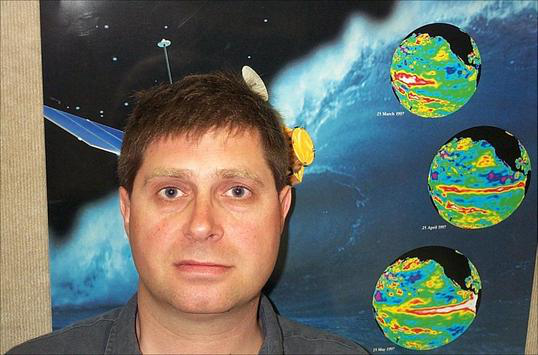

In [5]:
print('Number of samples: ', len(caltech_data))
img, target = caltech_data[3] # fourth sample
display(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 2) Standardize the images

In [6]:
transform_img = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x) # unify number of channels
])

caltech_data = dset.Caltech101("data", transform=transform_img, target_type="category", download=True)

target: Faces, shape: (355, 538, 3)


Files already downloaded and verified


In [7]:
def mean_and_std(loader):
    counter = 0
    ev = torch.empty(3)
    var = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        number_of_pixels = b * h * w
        # sums over each channel
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        # expected value
        ev = (counter * ev + sum_) / (counter + number_of_pixels)
        # variance
        var = (counter * var + sum_of_square) / (counter + number_of_pixels)
        counter += number_of_pixels

    mean, std = ev, torch.sqrt(var - ev ** 2)        
    return mean,std

In [8]:
BATCH_SIZE = 4
image_data_loader = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std = mean_and_std(image_data_loader)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")

Statistics of the whole dataset:
mean = tensor([0.5390, 0.5173, 0.4887])
std = tensor([0.3056, 0.2996, 0.3121])


In [9]:
# https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html 
transform_standardization = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(mean, std)
])

caltech_data = dset.Caltech101("data", transform=transform_standardization, target_type="category", download=True)

Files already downloaded and verified


In [10]:
# CHECK WHETHER mean == 0 and std == 1
image_data_loader_stand = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std = mean_and_std(image_data_loader_stand)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")
assert torch.le(mean.abs(), 0.001).all(), "Not all of the channels have mean equal to 0"
assert torch.isclose(std, torch.ones_like(std), atol=0.001).all(), "Not all of the channels have standard deviation equal to 1"

Statistics of the whole dataset:
mean = tensor([-4.4689e-07, -1.2186e-08,  8.0951e-07])
std = tensor([1.0000, 1.0000, 1.0000])


In [11]:
def display_img_tensor(img):
    images_np = img.numpy()
    img_plt = images_np.transpose(1,2,0)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(np.clip(img_plt, 0, 1))

target: Faces, shape: (3, 256, 256)


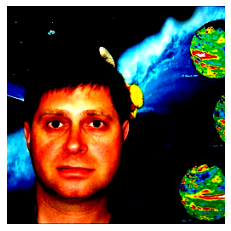

In [12]:
img, target = caltech_data[3]
display_img_tensor(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 3) Divide the collection into Train and Test set

In [13]:
# check the number of samples in each class
classes_count = dict(Counter(caltech_data.y))
classes_count = sorted(classes_count.items(), key=lambda item: item[1], reverse=True)
print("(id, number of samples)")
print(*classes_count[:35])

(id, number of samples)
(5, 800) (3, 798) (0, 435) (1, 435) (94, 239) (2, 200) (12, 128) (19, 123) (55, 114) (23, 107) (47, 100) (46, 99) (13, 98) (16, 91) (50, 88) (63, 87) (54, 86) (86, 86) (92, 86) (15, 85) (39, 85) (90, 85) (81, 84) (75, 82) (57, 81) (51, 80) (58, 78) (65, 76) (35, 75) (93, 75) (26, 73) (27, 70) (25, 69) (34, 68) (31, 67)


In [14]:
# take 20 classes with about 80 examples each
N_CLASSES = 20
chosen_classes = [item[0] for item in classes_count[12:12+N_CLASSES]]
res_list = map(categories.__getitem__, chosen_classes)
print("Selected classes:")
print(*res_list)

Selected classes:
brain butterfly helicopter menorah kangaroo starfish trilobite buddha ewer sunflower scorpion revolver laptop ibis llama minaret electric_guitar umbrella crab crayfish


In [15]:
idx, classes = [], []

for i, cl in enumerate(caltech_data.y):
    if cl in chosen_classes:
        idx.append(i)
        classes.append(cl)

In [16]:
# split
train_indices, test_indices = train_test_split(idx, test_size=0.3, stratify=classes)
len(train_indices), len(test_indices)

(1155, 496)

In [66]:
BATCH_SIZE = 4

train_set = torch.utils.data.Subset(caltech_data, train_indices)
test_set = torch.utils.data.Subset(caltech_data, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [18]:
def check_sets(loader, show_idx=-1):
    stats_dict = dict()
    i = 0
    for images, labels in loader:
        for  img, lab in zip(images, labels):
          if i == show_idx:
              print('EXEMPLARY IMAGE')
              print(f'Label: {categories[lab]}')
              print(f'Shape: {img.shape}')
              display_img_tensor(img)
          i+=1
          if categories[lab] in stats_dict.keys():
            stats_dict[categories[lab]] += 1
          else:
            stats_dict[categories[lab]] = 1
    return stats_dict

EXEMPLARY IMAGE
Label: electric_guitar
Shape: torch.Size([3, 256, 256])


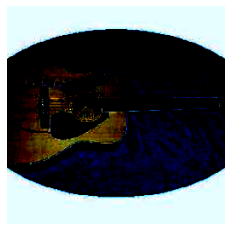

In [19]:
train_stats = check_sets(train_loader, show_idx=10)

EXEMPLARY IMAGE
Label: helicopter
Shape: torch.Size([3, 256, 256])


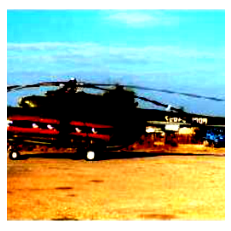

In [20]:
test_stats = check_sets(test_loader, show_idx=10)

In [21]:
assert train_stats.keys() == test_stats.keys()
denom_train = sum(train_stats.values()) # or alternatively len(train_indices)
denom_test = sum(test_stats.values())
print("CHECK CLASS PROPORTIONS IN BOTH SETS:")
for key in train_stats.keys():
    print(f'key: {str.upper(key)}\t\ttrain: {round(train_stats[key]/denom_train*100, 2)}%,\t\ttest: {round(test_stats[key]/denom_test*100,2)}%')

CHECK CLASS PROPORTIONS IN BOTH SETS:
key: REVOLVER		train: 4.94%,		test: 5.04%
key: BUDDHA		train: 5.11%,		test: 5.24%
key: LAPTOP		train: 4.94%,		test: 4.84%
key: TRILOBITE		train: 5.19%,		test: 5.24%
key: UMBRELLA		train: 4.59%,		test: 4.44%
key: BRAIN		train: 5.97%,		test: 5.85%
key: LLAMA		train: 4.76%,		test: 4.64%
key: HELICOPTER		train: 5.37%,		test: 5.24%
key: ELECTRIC_GUITAR		train: 4.5%,		test: 4.64%
key: IBIS		train: 4.85%,		test: 4.84%
key: EWER		train: 5.11%,		test: 5.24%
key: SUNFLOWER		train: 5.11%,		test: 5.24%
key: MINARET		train: 4.59%,		test: 4.64%
key: MENORAH		train: 5.28%,		test: 5.24%
key: STARFISH		train: 5.19%,		test: 5.24%
key: CRAB		train: 4.42%,		test: 4.44%
key: KANGAROO		train: 5.19%,		test: 5.24%
key: BUTTERFLY		train: 5.54%,		test: 5.44%
key: SCORPION		train: 5.11%,		test: 5.04%
key: CRAYFISH		train: 4.24%,		test: 4.23%


In [175]:
# ONE HOT ENCODING
def get_data_one_hot(train_indices, test_indices, caltech_data):
    x = torch.tensor([range(N_CLASSES)])
    one_hot_encoded = F.one_hot(x, num_classes=N_CLASSES)
    one_hot_encoded = torch.squeeze(one_hot_encoded)
    # print(one_hot_encoded.shape)

    train_label_ids = list({caltech_data.y[i] for i in train_indices}) # list from the set of labels, hence can be either train_indices or test_indices
    temp_dict = dict(list(enumerate(train_label_ids)))
    temp_dict_reversed = dict()
    dict_new_label = dict()
    dict_old_label  = dict()

    for key, value in temp_dict.items():
        one_hot = tuple(one_hot_encoded[key].tolist())
        dict_old_label[one_hot] = value
        dict_new_label[value] = one_hot
        temp_dict_reversed[value] = key
    # print(dict_new_label)
    # print(dict_old_label)

    train_data, test_data = [], []
    for idx in train_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        train_data.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
    for idx in test_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        test_data.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
        
    return train_data, test_data, (dict_old_label, dict_new_label)

In [176]:
train_data, test_data, dicts = get_data_one_hot(train_indices, test_indices, caltech_data)

In [188]:
def get_label_from_tensor(tensor, dict_old_label, categories):
    # print(tuple(tensor.tolist()))
    return categories[dict_old_label[tuple(tensor.tolist())]]

ibis
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


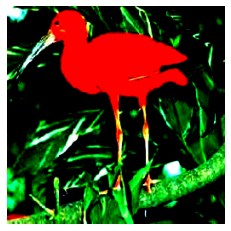

In [229]:
# CHECK TRAIN SET
x = 13
print(get_label_from_tensor(train_data[x][1], dicts[0], categories))
print(train_data[x][1])
display_img_tensor(train_data[x][0])

laptop
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


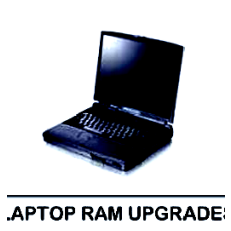

In [228]:
# CHECK TEST SET
x = 29
print(get_label_from_tensor(test_data[x][1], dicts[0], categories))
print(test_data[x][1])
display_img_tensor(test_data[x][0])

### 4) Define the model 

In [266]:
class ConvModel(nn.Module):
    def __init__(self, in_channels, num_of_classes):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 8, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(8 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [261]:
model = ConvModel(3, N_CLASSES)

# print(f"Model structure: {model}\n\n")
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [262]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 5) Train the model

In [263]:
BATCH_SIZE = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [267]:
def train_model(model, optimizer, data_loader, loss_module, epochs=250):
    model.train()
    # device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Training loop
    for epoch in tqdm(range(epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            # data_inputs = data_inputs.to(device)
            # data_labels = data_labels.to(device)

            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # [BATCH_SIZE, 1], change it to [BATCH_SIZE]

            loss = loss_module(preds, data_labels.float())
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

In [268]:
train_model(model, optimizer, train_loader, criterion, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x8192 and 2x512)

### 6) Save the model to disk

### 7) Summary of the Part 1 - describe your observations

## Part 2 - Experimental comparative analysis

In [ ]:
# choose >= 3 tasks